<a href="https://colab.research.google.com/github/Shehbaz-Niazi/Agentic_AI-PROJECTS/blob/main/ADVANCE_FACE_RAG_DETECTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Step 1**

In [ ]:
!pip install -q facenet-pytorch
!pip install -q pinecone-client
!pip install -q langchain
!pip install -q --upgrade pillow
!pip install -U langchain-community

# **Step 2**

In [2]:
import requests
import torch
import pinecone
from facenet_pytorch import MTCNN, InceptionResnetV1
from PIL import Image
from io import BytesIO
from uuid import uuid4
from pinecone import Pinecone, ServerlessSpec
import time

# **Step 3**

In [ ]:
# Initialize Pinecone
from google.colab import userdata

pinecone_api_key = userdata.get('PINECONE_API_KEY')
pc = Pinecone(api_key=pinecone_api_key)
index_name = "rag-face-detection"

dimension = 512  # Correct dimension for InceptionResnetV1
if index_name not in [idx["name"] for idx in pc.list_indexes()]:
    pc.create_index(
        name=index_name,
        dimension=dimension,
        metric="cosine",
        spec=ServerlessSpec(cloud="aws", region="us-east-1"),
    )
    while not pc.describe_index(index_name).status["ready"]:
        time.sleep(1)
index = pc.Index(index_name)

# Initialize Face Detection and Embedding Model
mtcnn = MTCNN(image_size=160, margin=0, post_process=False)
inception = InceptionResnetV1(pretrained="vggface2").eval()

# **Step 4**

In [5]:
def get_face_embedding_from_url(image_url):
    try:
        response = requests.get(image_url)
        response.raise_for_status()
        image = Image.open(BytesIO(response.content))
        faces = mtcnn(image)

        if faces is not None:
            if faces.ndimension() == 3:
                faces = faces.unsqueeze(0)
            embeddings = inception(faces)
            return embeddings.detach().cpu().numpy()
        else:
            print(f"No faces detected in image: {image_url}")
            return None
    except Exception as e:
        print(f"Error processing image {image_url}: {e}")
        return None

# **Step 5**

In [28]:
dataset = [
    {"name": "Muhammad Hafeez", "url": "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcT2wW-ZM7pXfwYdwaqut59-LJRO-pWhYk0nTiwB6jLv3TKeg66IzRxA_TIKP8Sj96_bQlY&usqp=CAU"},
    {"name": "Sarfaraz Ahmed", "url": "https://resize.indiatvnews.com/en/resize/newbucket/1200_-/2019/07/sarfaraz-ahmed-1562422817.jpg"},
    {"name": "Fakhar Zaman", "url": "https://propakistani.pk/wp-content/uploads/2024/09/fakhar-zaman.jpg"},
    {"name": "Shahid Afridi", "url": "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcT1KDL3ldC-CgcP8R4WHWzjIgmAyTxZbL1P7w&s"},
    {"name": "Shahid Afridi", "url": "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRB7VX4yuvpFxgwbwmIG94i3g1iKNYHGw6paw&s"},
]

# **Step 6**

In [29]:
for person in dataset:
    embedding = get_face_embedding_from_url(person["url"])
    if embedding is not None:
        vector_id = str(uuid4())
        metadata = {"name": person["name"]}
        index.upsert(vectors=[(vector_id, embedding.flatten().tolist(), metadata)])

print("✅ Face embeddings stored in Pinecone!")


✅ Face embeddings stored in Pinecone!


# **Step 7**

# **Face Matching and Similarity Search in Python**

In [30]:
def find_similar_faces(image_url, top_k=1):
    embedding = get_face_embedding_from_url(image_url)
    if embedding is None:
        print("❌ No face detected, cannot search.")
        return None

    # Query Pinecone
    query_results = index.query(vector=embedding.flatten().tolist(), top_k=top_k, include_metadata=True)

    # Show results
    if query_results and "matches" in query_results:
        for match in query_results["matches"]:
            print(f"✅ Match Found: {match['metadata']['name']} (Score: {match['score']:.2f})")
    else:
        print("❌ No similar face found.")

# Test with a new image
test_image_url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcT2wW-ZM7pXfwYdwaqut59-LJRO-pWhYk0nTiwB6jLv3TKeg66IzRxA_TIKP8Sj96_bQlY&usqp=CAU"
find_similar_faces(test_image_url, top_k=2)


✅ Match Found: Muhammad Hafeez (Score: 1.00)
✅ Match Found: Sarfaraz Ahmed (Score: 0.96)


# **Step 8**

# **Face Detection Using MTCNN in Python**

✅ 1 face(s) detected.


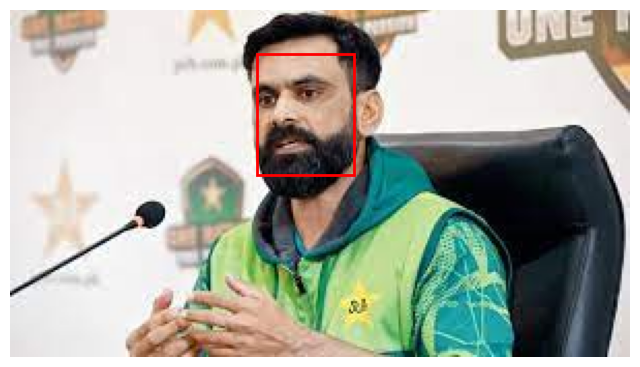

In [39]:
import matplotlib.pyplot as plt

def detect_faces(image_url):
    try:
        response = requests.get(image_url)
        response.raise_for_status()
        image = Image.open(BytesIO(response.content))

        # Face detection using MTCNN
        boxes, _ = mtcnn.detect(image)

        if boxes is not None:
            print(f"✅ {len(boxes)} face(s) detected.")

            # Draw boxes around detected faces
            fig, ax = plt.subplots(figsize=(8, 8))
            ax.imshow(image)
            for box in boxes:
                x, y, x2, y2 = box
                rect = plt.Rectangle((x, y), x2 - x, y2 - y, linewidth=2, edgecolor='red', facecolor='none')
                ax.add_patch(rect)

            plt.axis("off")
            plt.show()
        else:
            print("❌ No face detected in the image.")
    except Exception as e:
        print(f"Error: {e}")

# Test with an image
test_image_url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSuc9XuO236L0nujwI3X5NWB-OYpw8hp_AhaQX4GtC9QbV2I7niC7aaEunh5Y56stpKqAk&usqp=CAU"
detect_faces(test_image_url)


# **Step 9**

# **Face Recognition from Image URL Using MTCNN & Pinecone in Python**

In [40]:
from google.colab import files
import requests
from PIL import Image
from io import BytesIO

# ✅ Function 1: Recognize Face from Image URL
def recognize_face_from_url(image_url, top_k=1, threshold=0.6):
    """
    - image_url: Online image ka URL
    """
    try:
        # ✅ Step 1: Load image from URL
        response = requests.get(image_url)
        response.raise_for_status()
        image = Image.open(BytesIO(response.content))
        print("✅ Image loaded from URL.")

        # ✅ Step 2: Get face embedding
        faces = mtcnn(image)
        if faces is None:
            return "❌ No face detected in the input image."

        if faces.ndimension() == 3:
            faces = faces.unsqueeze(0)

        embedding = inception(faces).detach().cpu().numpy().flatten().tolist()

        # ✅ Step 3: Query Pinecone for similar faces
        query_results = index.query(vector=embedding, top_k=top_k, include_metadata=True)

        # ✅ Step 4: Check if any match is found
        if query_results["matches"]:
            best_match = query_results["matches"][0]  # Get top match
            similarity_score = best_match["score"]
            matched_name = best_match["metadata"]["name"]

            # ✅ Step 5: Check similarity threshold
            if similarity_score >= threshold:
                return f"➡️➡️ Matched with: {matched_name} (Score: {similarity_score:.2f})"
            else:
                return f"⚠️ Closest match: {matched_name}, but below threshold (Score: {similarity_score:.2f})"
        else:
            return "❌ No similar face found in database."

    except Exception as e:
        return f"Error: {e}"

In [41]:
# ✅ Test with Online Image URL
print(recognize_face_from_url("https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcSuc9XuO236L0nujwI3X5NWB-OYpw8hp_AhaQX4GtC9QbV2I7niC7aaEunh5Y56stpKqAk&usqp=CAU"))


✅ Image loaded from URL.
➡️➡️ Matched with: Muhammad Hafeez (Score: 0.98)


________________________________________________________________________________
________________________________________________________________________________

# **Step 10**

# **Face Recognition from Local File Upload Using MTCNN & Pinecone in Python**

In [42]:
# ✅ Function 2: Recognize Face from Local File Upload
def recognize_face_from_local(top_k=1, threshold=0.6):
    """
    - Google Colab me manually image upload kare aur uska face recognition kare.
    """
    try:
        print("📂 Please upload an image...")
        uploaded = files.upload()  # File upload karega
        image_path = list(uploaded.keys())[0]  # Uploaded file ka path
        image = Image.open(image_path)
        print(f"✅ Image uploaded: {image_path}")

        # ✅ Step 2: Get face embedding
        faces = mtcnn(image)
        if faces is None:
            return "❌ No face detected in the input image."

        if faces.ndimension() == 3:
            faces = faces.unsqueeze(0)

        embedding = inception(faces).detach().cpu().numpy().flatten().tolist()

        # ✅ Step 3: Query Pinecone for similar faces
        query_results = index.query(vector=embedding, top_k=top_k, include_metadata=True)

        # ✅ Step 4: Check if any match is found
        if query_results["matches"]:
            best_match = query_results["matches"][0]  # Get top match
            similarity_score = best_match["score"]
            matched_name = best_match["metadata"]["name"]

            # ✅ Step 5: Check similarity threshold
            if similarity_score >= threshold:
                return f"➡️➡️ Matched with: {matched_name} (Score: {similarity_score:.2f})"
            else:
                return f"⚠️ Closest match: {matched_name}, but below threshold (Score: {similarity_score:.2f})"
        else:
            return "❌ No similar face found in database."

    except Exception as e:
        return f"Error: {e}"

In [43]:
# ✅ Test with Manual File Upload
print(recognize_face_from_local())  # Ye function manually file upload karega

📂 Please upload an image...


Saving Hafeez.jpg to Hafeez.jpg
✅ Image uploaded: Hafeez.jpg
➡️➡️ Matched with: Muhammad Hafeez (Score: 0.98)


____________________________________________________________________________
___________________________________________________________________________


____________________________________________________________________________
___________________________________________________________________________

# **Extra Steps Step 11 and 12**

```
# This Two Steps is Extra. it is using for clearification
```



# **Step 11**

# **Face Recognition from Image URL Using MTCNN & Pinecone in Python and Show Matched Images**

In [44]:
import matplotlib.pyplot as plt
import requests
from PIL import Image
from io import BytesIO
from google.colab import files

# ✅ Utility Function: Show Image
def show_image(image, title="Matched Face"):
    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.title(title)
    plt.axis("off")
    plt.show()

# ✅ Function 1: Recognize Face from URL
def recognize_face_from_url(image_url, top_k=1, threshold=0.6):
    """
    - image_url: Online image ka URL
    """
    try:
        # ✅ Step 1: Load image from URL
        response = requests.get(image_url)
        response.raise_for_status()
        image = Image.open(BytesIO(response.content))
        print("✅ Image loaded from URL.")

        # ✅ Step 2: Get face embedding
        faces = mtcnn(image)
        if faces is None:
            print("❌ No face detected in the input image.")
            return

        if faces.ndimension() == 3:
            faces = faces.unsqueeze(0)

        embedding = inception(faces).detach().cpu().numpy().flatten().tolist()

        # ✅ Step 3: Query Pinecone for similar faces
        query_results = index.query(vector=embedding, top_k=top_k, include_metadata=True)

        # ✅ Step 4: Check if any match is found
        if query_results["matches"]:
            best_match = query_results["matches"][0]
            similarity_score = best_match["score"]
            matched_name = best_match["metadata"]["name"]

            # ✅ Step 5: Check similarity threshold
            if similarity_score >= threshold:
                print(f"➡️➡️ Matched with: {matched_name} (Score: {similarity_score:.2f})")

                # ✅ Show Matched Image
                show_image(image, title=f"Matched: {matched_name} (Score: {similarity_score:.2f})")
            else:
                print(f"⚠️ Closest match: {matched_name}, but below threshold (Score: {similarity_score:.2f})")
        else:
            print("❌ No similar face found in database.")

    except Exception as e:
        print(f"Error: {e}")

✅ Image loaded from URL.
➡️➡️ Matched with: Sarfaraz Ahmed (Score: 1.00)


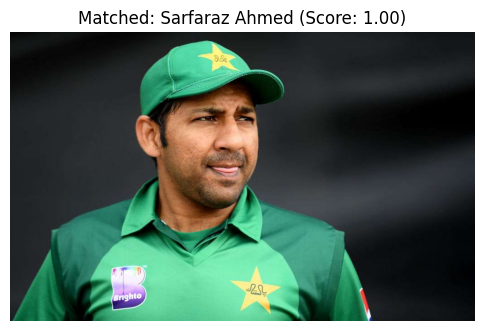

None


In [46]:
# ✅ Test with Online Image URL
print(recognize_face_from_url("https://resize.indiatvnews.com/en/resize/newbucket/1200_-/2019/07/sarfaraz-ahmed-1562422817.jpg"))

# **Step 12**

# **Face Recognition from Local Computer Using MTCNN & Pinecone in Python and Show Matched Images**

In [47]:
#  ✅ Function 2: Recognize Face from Local File Upload
def recognize_face_from_local(top_k=1, threshold=0.6):
    """
    - Google Colab me manually image upload kare aur uska face recognition kare.
    """
    try:
        print("📂 Please upload an image...")
        uploaded = files.upload()
        image_path = list(uploaded.keys())[0]
        image = Image.open(image_path)
        print(f"✅ Image uploaded: {image_path}")

        # ✅ Step 2: Get face embedding
        faces = mtcnn(image)
        if faces is None:
            print("❌ No face detected in the input image.")
            return

        if faces.ndimension() == 3:
            faces = faces.unsqueeze(0)

        embedding = inception(faces).detach().cpu().numpy().flatten().tolist()

        # ✅ Step 3: Query Pinecone for similar faces
        query_results = index.query(vector=embedding, top_k=top_k, include_metadata=True)

        # ✅ Step 4: Check if any match is found
        if query_results["matches"]:
            best_match = query_results["matches"][0]
            similarity_score = best_match["score"]
            matched_name = best_match["metadata"]["name"]

            # ✅ Step 5: Check similarity threshold
            if similarity_score >= threshold:
                print(f"✅ Matched with: {matched_name} (Score: {similarity_score:.2f})")

                # ✅ Show Matched Image
                show_image(image, title=f"Matched: {matched_name} (Score: {similarity_score:.2f})")
            else:
                print(f"⚠️ Closest match: {matched_name}, but below threshold (Score: {similarity_score:.2f})")
        else:
            print("❌ No similar face found in database.")

    except Exception as e:
        print(f"Error: {e}")


In [50]:
# ✅ Test with Manual File Upload
print(recognize_face_from_local())  # Local upload

📂 Please upload an image...


Error: list index out of range
None
